In [282]:
# Импортируем нужные библиотеки
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [283]:
pwd # рабочая папка

'c:\\Users\\vvtom\\YandexDisk\\Prog\\ITNordic\\Final_project'

In [284]:
# список входящих файлов
import os

for dirname, _, filenames in os.walk('c:\\Users\\vvtom\\YandexDisk\\Prog\\ITNordic\\Final_project\\input_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

c:\Users\vvtom\YandexDisk\Prog\ITNordic\Final_project\input_data\events.csv
c:\Users\vvtom\YandexDisk\Prog\ITNordic\Final_project\input_data\item_properties_part1.csv
c:\Users\vvtom\YandexDisk\Prog\ITNordic\Final_project\input_data\item_properties_part2.csv


In [285]:
# загружаем данные 
events_df = pd.read_csv('input_data\events.csv')
print(events_df.info())
print(events_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None
          timestamp     visitorid        itemid  transactionid
count  2.756101e+06  2.756101e+06  2.756101e+06   22457.000000
mean   1.436424e+12  7.019229e+05  2.349225e+05    8826.497796
std    3.366312e+09  4.056875e+05  1.341954e+05    5098.996290
min    1.430622e+12  0.000000e+00  3.000000e+00       0.000000
25%    1.433478e+12  3.505660e+05  1.181200e+05    4411.000000
50%    1.436453e+12  7.020600e+05  2.360670e+05    8813.000000
75%    1.439225e+12  1.053437e+06  3.507150e+05   13224.000000
max    1.442545e+12  1.407579e+06  4.668670e+05   17671.000000


In [286]:
# Предбработка ДФ 
def preproc(df):
    '''Preprocessing func: convert timestamp to datetime, drop column timestamp'''
    df['datetime'] = df.timestamp.apply(lambda ts: datetime.fromtimestamp(ts/1000)) # миллисекунды переводим в секунды
    df = df.drop('timestamp', axis=1)
    df = df.sort_values('datetime')
    df['diffdate'] = df.groupby('visitorid')['datetime'].diff(1)
    df['shiftdate'] = df.groupby('visitorid')['datetime'].shift(1)

    return df

preproc_events_df = preproc(events_df)

In [287]:
preproc_events_df.datetime.describe()

count                          2756101
mean     2015-07-09 09:48:08.348101888
min         2015-05-03 06:00:04.384000
25%         2015-06-05 07:23:14.792000
50%      2015-07-09 17:43:33.599000064
75%         2015-08-10 19:45:05.168000
max         2015-09-18 05:59:47.788000
Name: datetime, dtype: object

In [288]:
# Можно указать фильтр по датам (начало, окончание) для дальнейшей обработки данных
start_date, end_date = '2015-06-05', '2015-06-12'

def date_filter(df, start_date, end_date): # start_date и end_date в формате "%Y-%m-%d"
    '''Фильтр по времени'''
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)

    filter_data_events = df[(df.datetime > start_date)&(df.datetime < end_date)]
    return filter_data_events

# filter_events_df = date_filter(preproc_events_df, start_date, end_date)


In [289]:
def RFD(df, control_period = timedelta(minutes=15)):
    '''Функция создающая RFD таблицу'''
    # Данные столбца diffdate промежутки больше control_period и NAT приравниваем к timedelta(0)
    df['diffdate'][df.diffdate > control_period] = timedelta(0)
    df['diffdate'][df.diffdate.isna()] = timedelta(0)
    
    # Создаем датасет RFD_data с нужными для анализа столбцами
    temp = ['visitorid', 'itemid', 'transactionid', 'datetime', 'diffdate']
    RFD_data = df[temp]
    RFD_data['transaction_datetime'] = RFD_data.datetime.where(RFD_data.transactionid.notna()) #пользователи хотя бы с одной покупкой
    users_with_transactions = RFD_data.visitorid.where(RFD_data.transactionid.notna()).dropna().unique() # уникальные visitorid пользователей с хотя бы с одной покупкой
    RFD_data = RFD_data[RFD_data.visitorid.isin(users_with_transactions)]

    # Создаем таблицу RFD_table
    now = RFD_data.datetime.max() #максимальное время в датасете
    # Recency - свежесть: количество дней с последней покупки
    # Frequency - частота: количество покупок за весь измеряемый период
    # Duration - продолжительность: суммарная продолжительность периодов действий покупателей, промежуток между которыми < control_period
    RFD_table = RFD_data.groupby('visitorid').agg({'transaction_datetime': lambda x: (now - x.max()).days, # Recency
                                                'transactionid': lambda x: len(x.unique()), # Frequency
                                                'diffdate': sum # Duration
                                                })
    RFD_table.rename(columns={'transaction_datetime': 'R',
                            'transactionid': 'F',
                            'diffdate': 'D'}, inplace=True)
    
    # Ранжируем покупателей и ставим оценки в зависимости от возможности разделения по квантилям
    RFD_table['R_rank'] = pd.qcut(x=RFD_table.R, q=3, labels=[3, 2, 1])
    RFD_table['F_rank'] = pd.qcut(x=RFD_table.F, q=2, labels=[1,2])
    RFD_table['D_rank'] = pd.qcut(x=RFD_table.D, q=3, labels=[1,2,3])

    # Суммируем оценки R, F, D  
    RFD_table[['R_rank','F_rank','D_rank']] = RFD_table[['R_rank','F_rank','D_rank']].astype(int)
    RFD_table['RFD'] = RFD_table['R_rank'] + RFD_table['F_rank'] + RFD_table['D_rank']

    return RFD_table


In [290]:
# Задаем даты периодов
train_start_date, train_end_date = '2015-05-03', '2015-07-09' #первый период времени (в прошлом)
test_start_date, test_end_date = '2015-07-10', '2015-09-18' #второй период времени (в будущем)

train_events_df = date_filter(preproc_events_df, train_start_date, train_end_date) #данные за период '2015-05-03', '2015-07-09' 
test_events_df = date_filter(preproc_events_df, test_start_date, test_end_date) #данные за период '2015-07-10', '2015-09-18'

In [291]:
train_RFD = RFD(train_events_df)
train_RFD.RFD.describe()

C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diffdate'][df.diffdate > control_period] = timedelta(0)
C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diffdate'][df.diffdate.isna()] = timedelta(0)
C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

count    6031.000000
mean        5.114575
std         1.246010
min         3.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         8.000000
Name: RFD, dtype: float64

In [292]:
test_RFD = RFD(test_events_df)
test_RFD.RFD.describe()

C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diffdate'][df.diffdate > control_period] = timedelta(0)
C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diffdate'][df.diffdate.isna()] = timedelta(0)
C:\Users\vvtom\AppData\Local\Temp\ipykernel_24932\640028890.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

count    5810.000000
mean        5.094492
std         1.243826
min         3.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         8.000000
Name: RFD, dtype: float64

In [293]:
# Отношение RFD за периоды:
test_RFD.RFD.mean() / train_RFD.RFD.mean()
# в целом не значительное изменение общих средних показателей RFD в меньшую сторону

0.9960734872688854

Сравним показатели RFD покупателей, которые присутствуют в двух таблицах сразу (изменение поведения одних и тех же покупателей в разные периоды)

In [294]:
# Соединяем таблицы train_RFD и test_RFD по visitorid, чтобы сравнить тех же пользователей за разные отрезки времени
temp = ['R_rank', 'F_rank', 'D_rank', 'RFD']
trainandtest_RFD = train_RFD[temp].merge(test_RFD[temp], on= 'visitorid', how='inner', suffixes=('_train', '_test'))
# Сравниваем показатели RFD_train и RFD_test
trainandtest_RFD['RFD_diff'] = np.where(trainandtest_RFD['RFD_test'] == trainandtest_RFD['RFD_train'],0, trainandtest_RFD['RFD_test'] - trainandtest_RFD['RFD_train'])


In [295]:
# Записываем таблицу trainandtest_RFD в csv файл
trainandtest_RFD.to_csv(path_or_buf='output_data/trainandtest_RFD.csv')

In [296]:
trainandtest_RFD.RFD_diff.describe()

count    122.000000
mean      -0.663934
std        1.674360
min       -5.000000
25%       -2.000000
50%       -1.000000
75%        0.000000
max        3.000000
Name: RFD_diff, dtype: float64

In [297]:
# У какого процента покупателей отрицательные изменения RFD
RFD_diff_less_zero = ((trainandtest_RFD.RFD_diff[trainandtest_RFD.RFD_diff < 0].count()/trainandtest_RFD.RFD_diff.count())*100)
print(f'{RFD_diff_less_zero:.2f}%')

50.82%


In [298]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [299]:
# mpl.style.use(['ggplot'])

In [300]:
# Датасет для построения графиков
tt = trainandtest_RFD.RFD_diff.reset_index()
tt.visitorid = tt.visitorid.astype(str) # преобразовываем visitorid в str чтобы на графиках отображались все значения
tt

,visitorid,RFD_diff
0,12506,-2
1,42552,2
2,79721,0
3,83600,2
4,85658,0
...,...,...
117,1352044,3
118,1365706,3
119,1379388,-2
120,1398811,-1


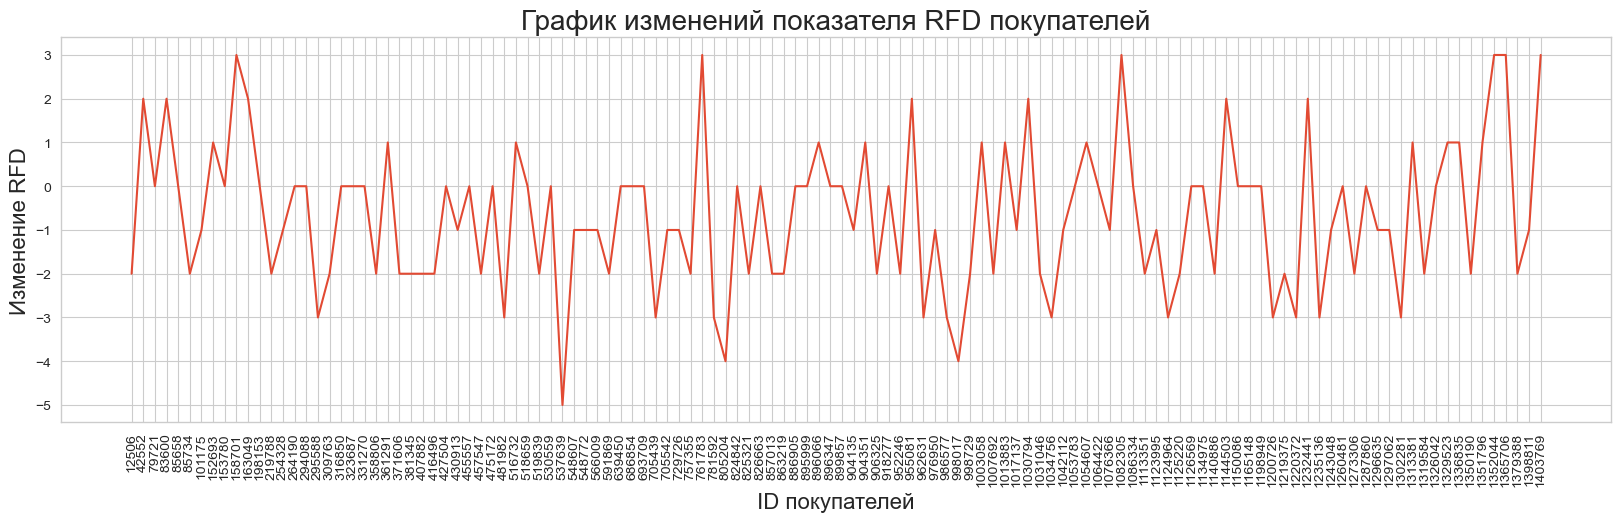

In [301]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
sns.lineplot(
    x="visitorid", 
    y="RFD_diff",
    data=tt)
# изменить размер шрифта отдельных элементов
plt.xlabel('ID покупателей', fontsize=16)
plt.ylabel('Изменение RFD', fontsize=16)
plt.title('График изменений показателя RFD покупателей', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=10, rotation=90, labelleft=False)

Text(0, 0.5, 'Количество покупателей')

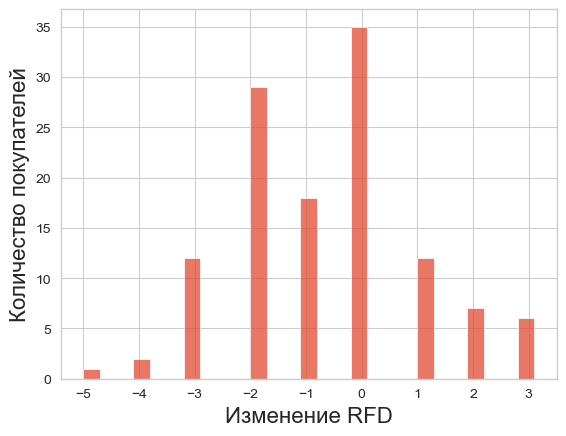

In [302]:
sns.histplot(tt["RFD_diff"], binwidth=0.3)
plt.xlabel('Изменение RFD', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)

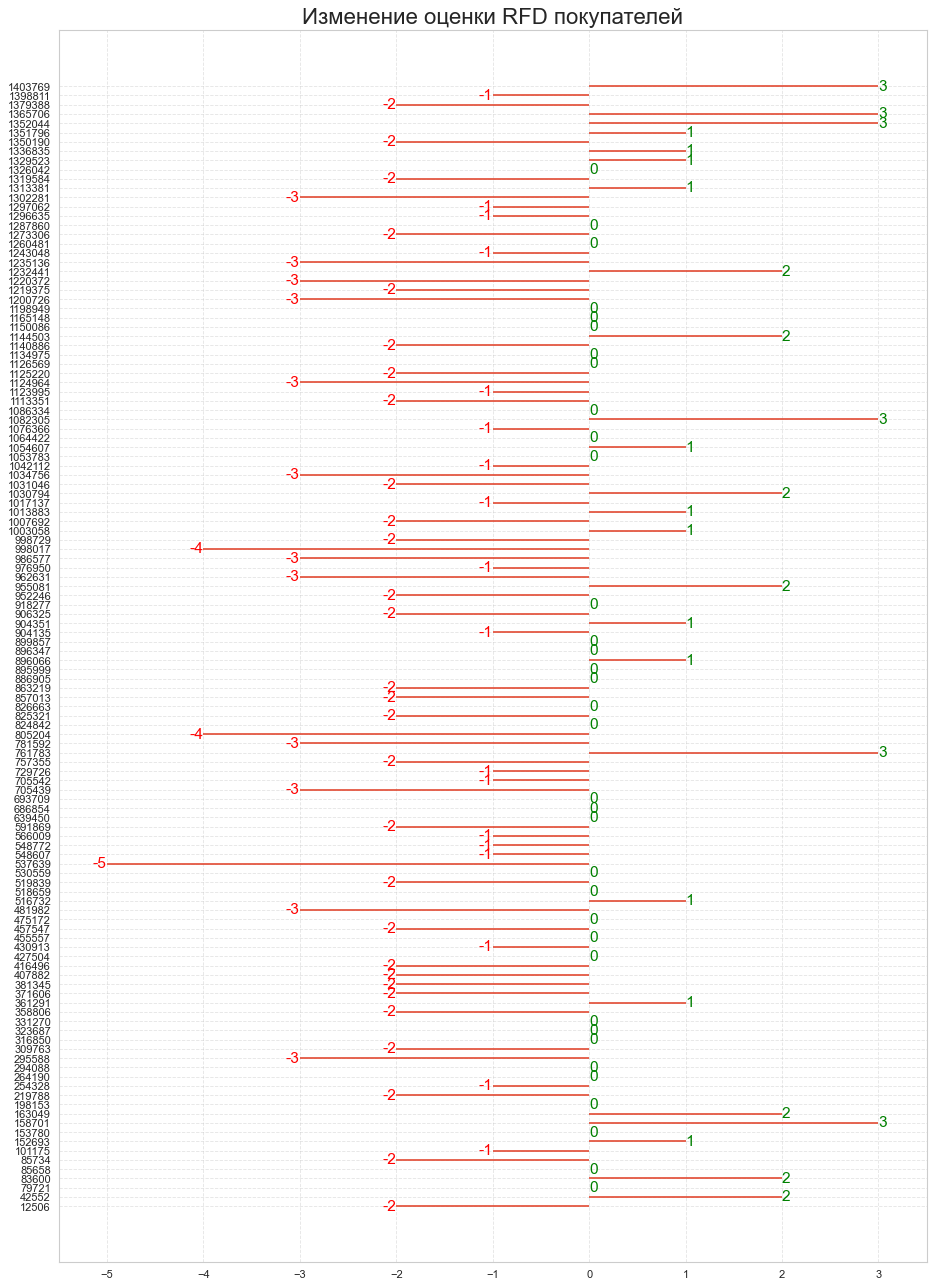

In [303]:
plt.figure(figsize=(14,20), dpi= 80)
plt.hlines(y=tt.visitorid, xmin=0, xmax=tt.RFD_diff)
for x, y, tex in zip(tt.RFD_diff, tt.visitorid, tt.RFD_diff):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

# Decorations    

plt.yticks(tt.visitorid, fontsize=10)
plt.title('Изменение оценки RFD покупателей', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-5.5, 3.5)
plt.show()

Формулируем гипотезу: 

"Покупатели с более высокими показателями RFD в прошлом(train_RFD RFD>=7) будут не менее (>=) лояльными в будущем(test_RFD)"

In [304]:
best_buyers_train = train_RFD[train_RFD.RFD >= 7]
best_buyers_train

,R,F,D,R_rank,F_rank,D_rank,RFD
visitorid,,,,,,,
3258,17,2,0 days 00:21:20.411000,3,1,3,7
4115,12,2,0 days 00:25:57.802000,3,1,3,7
8731,21,3,0 days 00:22:36.869000,3,2,3,8
11333,5,3,0 days 00:47:55.465000,3,2,3,8
11462,0,2,0 days 01:05:26.735000,3,1,3,7
...,...,...,...,...,...,...,...
1390313,17,2,0 days 00:23:04.169000,3,1,3,7
1397340,2,3,0 days 00:10:37.047000,3,2,2,7
1398505,12,3,0 days 00:19:35.421000,3,2,3,8


In [305]:
# Соединяем таблицы train_RFD и test_RFD по visitorid, чтобы сравнить тех же пользователей за разные отрезки времени
temp = ['R_rank', 'F_rank', 'D_rank', 'RFD']
best_buyers_trainandtest_RFD = best_buyers_train[temp].merge(test_RFD[temp], on= 'visitorid', how='inner', suffixes=('_train', '_test'))
best_buyers_trainandtest_RFD
# Сравниваем показатели RFD_train и RFD_test
best_buyers_trainandtest_RFD['RFD_diff'] = np.where(best_buyers_trainandtest_RFD['RFD_test'] == best_buyers_trainandtest_RFD['RFD_train'],0, best_buyers_trainandtest_RFD['RFD_test'] - best_buyers_trainandtest_RFD['RFD_train'])
best_buyers_trainandtest_RFD.RFD_diff.describe()

count    59.000000
mean     -1.220339
std       1.300766
min      -5.000000
25%      -2.000000
50%      -1.000000
75%       0.000000
max       1.000000
Name: RFD_diff, dtype: float64

In [306]:
# Запись таблицы в csv файл
best_buyers_trainandtest_RFD.to_csv(path_or_buf='output_data/bb_trainandtest_RFD.csv')

In [307]:
# У какого процента лучших покупателей отрицательные изменения RFD
bb_RFD_diff_less_zero = ((best_buyers_trainandtest_RFD.RFD_diff[best_buyers_trainandtest_RFD.RFD_diff < 0].count()/best_buyers_trainandtest_RFD.RFD_diff.count())*100)
print(f'{bb_RFD_diff_less_zero:.2f}%')

62.71%


In [308]:
bb = best_buyers_trainandtest_RFD.RFD_diff.reset_index()
bb.visitorid = bb.visitorid.astype(str)

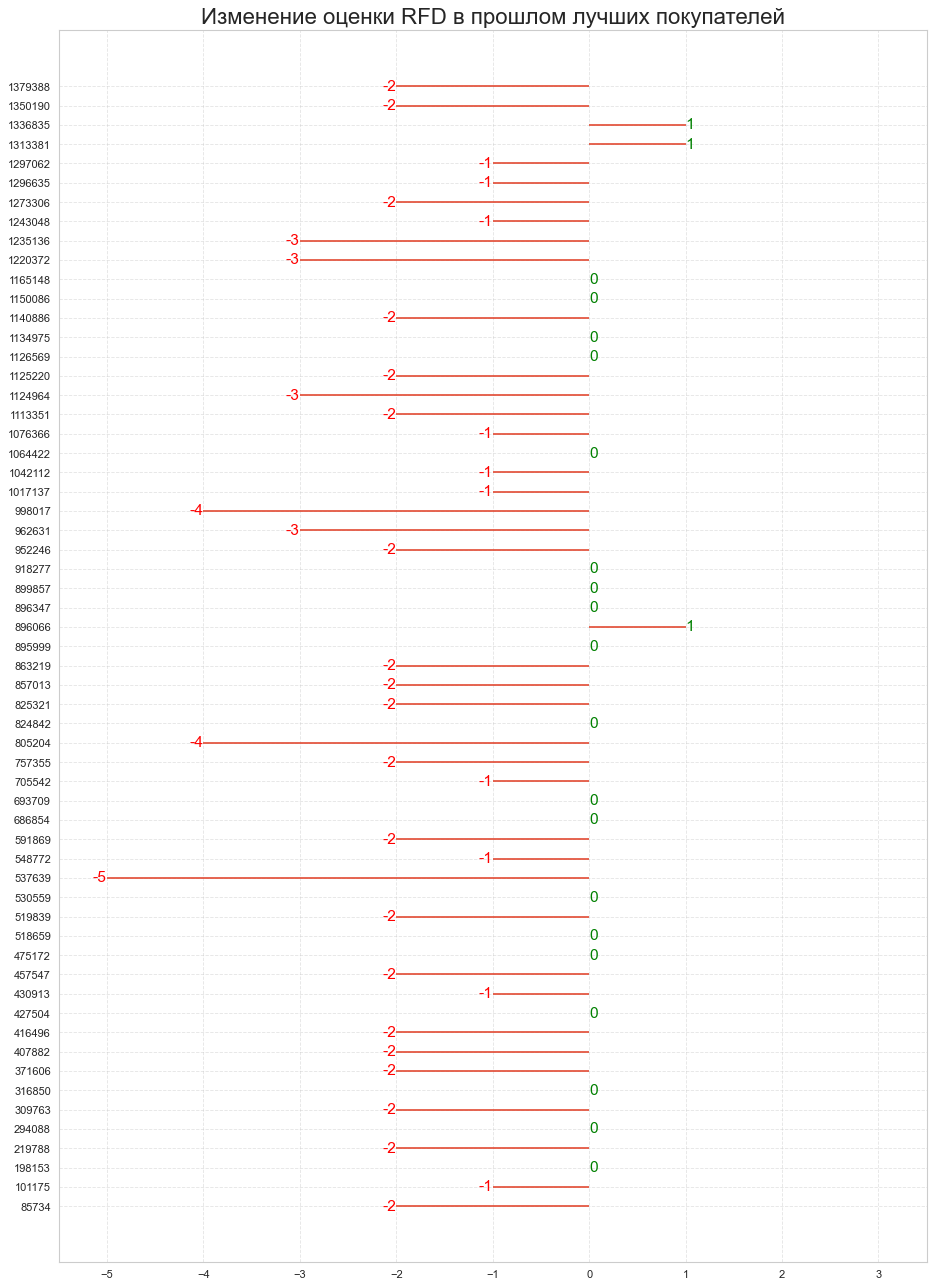

In [309]:
plt.figure(figsize=(14,20), dpi= 80)
plt.hlines(y=bb.visitorid, xmin=0, xmax=bb.RFD_diff)
for x, y, tex in zip(bb.RFD_diff, bb.visitorid, bb.RFD_diff):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

# Decorations    

plt.yticks(bb.visitorid, fontsize=10)
plt.title('Изменение оценки RFD в прошлом лучших покупателей', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-5.5, 3.5)
plt.show()

Гепотеза опровергнута